In [ ]:
#  Video Summary Pipeline Assignment

#   Overview
#   This notebook implements a pipeline to summarize YouTube videos for an ML-CV Intern assignment. The pipeline:
# - Downloads videos and extracts metadata using `yt-dlp`.
# - Extracts transcripts with `youtube-transcript-api` or transcribes audio with `Whisper`.
# - Summarizes content using `Mistral AI`.
# - Extracts visual text from frames using `OpenCV` and `Tesseract OCR`.
# - Generates a detailed Markdown report.

# ## Assignment Details
# - Videos:
# - English: "How to EASILY Kick Start A Healthy Lifestyle FAST!! (For FREE!!)" - [https://www.youtube.com/watch?v=2QHQ9NKWKE8](https://www.youtube.com/watch?v=2QHQ9NKWKE8)
# - Hindi: "Apple Cider Vinegar for Weight Management (in Hindi)" - [https://www.youtube.com/watch?v=SfAxH89T4MA](https://www.youtube.com/watch?v=SfAxH89T4MA)
# - Tasks: Download videos, extract transcripts and metadata, summarize, optionally extract visual text.
# - Expectations: Explain pipeline and model choices, run end-to-end on one video, ensure flexibility, provide verbose documentation, and prepare for a walkthrough.
# - Output: IPYNB notebook and Markdown report.

# ## Execution Note
# This notebook processes the Hinglish video that doesnt have a transcript and uses whisper from openAI to transcribe the audio (if the video doesn't have a transcript and triggers a fallback mechanism). 
# The other videos are processed using the youtube-transcript-api.

In [ ]:
# # ===========================================================================
# # SECTION 1: SETUP AND INSTALL DEPENDENCIES
# # ===========================================================================
# # Purpose: Install and import all required libraries with explanations for each


# # Install Python libraries
# !pip install yt_dlp                 # For downloading YouTube videos and metadata
# !pip install youtube-transcript-api # For fetching YouTube transcripts if available
# !pip install langchain-mistralai   # For integrating Mistral AI summarization
# !pip install pydub                 # For audio processing (e.g., format conversion)
# !pip install opencv-python         # For video frame processing in visual extraction
# !pip install pillow                # For image handling and display
# !pip install matplotlib            # For visualizing sample frames
# !pip install langdetect            # For detecting transcript language (e.g., 'en', 'hi')
# !pip install git+https://github.com/openai/whisper.git  # For audio transcription

# # Install Tesseract OCR and Hindi language pack
# !apt-get update
# !apt-get install -y tesseract-ocr      # OCR engine for extracting text from frames
# !apt-get install -y tesseract-ocr-hin  # Hindi support for OCR

# Import required modules
import os
import yt_dlp
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound, TranscriptsDisabled
from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage, HumanMessage
from pydub import AudioSegment
import cv2
import subprocess
import tempfile
from PIL import Image
import matplotlib.pyplot as plt
from langdetect import detect
import whisper

print("SECTION 1 COMPLETE: All dependencies installed and imported.")

SECTION 1 COMPLETE: All dependencies installed and imported.


In [ ]:
# ===========================================================================
# SECTION 2: SET API KEY MANUALLY
# ===========================================================================
# Purpose: Define the Mistral AI API key directly in the code

api_key = "Yk0jCzWir3ghtSrShkqjHB6NKaANMUAm"  # Hardcoded Mistral AI API key

# Validate the API key
if not api_key:
    raise ValueError("API key missing! Set it manually in the api_key variable.")
print("SECTION 2 COMPLETE: API key set successfully.")

SECTION 2 COMPLETE: API key set successfully.


In [3]:
# ===========================================================================
# SECTION 3: INITIALIZE MISTRAL AI MODEL
# ===========================================================================
# Purpose: Set up the Mistral AI model for summarization
# Model: mistral-large-latest chosen for its strong natural language processing
llm = ChatMistralAI(model="mistral-large-latest", api_key=api_key)
print("SECTION 3 COMPLETE: Mistral AI model initialized.")

SECTION 3 COMPLETE: Mistral AI model initialized.


In [2]:
# ===========================================================================
# SECTION 4: DEFINE VIDEO URL
# ===========================================================================
# Purpose: Specify the YouTube video URL to process
input_video_url = "https://www.youtube.com/watch?v=LGHUSjQelyc"  # Enter the video URL
video_url = input_video_url
print(f"SECTION 4 COMPLETE: Processing video URL: {video_url}")

SECTION 4 COMPLETE: Processing video URL: https://www.youtube.com/watch?v=LGHUSjQelyc


In [7]:
# ===========================================================================
# SECTION 5: DOWNLOAD VIDEO AND EXTRACT METADATA
# ===========================================================================
# Purpose: Download the video and retrieve metadata for the report
def download_video(url, output_dir='videos'):
    """Download YouTube video and extract metadata.
    Args:
        url (str): YouTube video URL
        output_dir (str): Directory to save the video
    Returns:
        video_path (str): Path to downloaded video
        info (dict): Metadata dictionary (title, description, etc.)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create directory if it doesn't exist
    ydl_opts = {
        'outtmpl': os.path.join(output_dir, '%(title)s.%(ext)s'),  # File naming
        'format': 'mp4',  # Preferred video format
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)  # Download and extract info
        video_path = ydl.prepare_filename(info)      # Get saved file path
    return video_path, info

# Download and extract metadata
video_path, metadata = download_video(video_url)
print(f"SECTION 5 COMPLETE: Video downloaded to {video_path}")
print("Metadata keys:", list(metadata.keys()))

[youtube] Extracting URL: https://www.youtube.com/watch?v=LGHUSjQelyc
[youtube] LGHUSjQelyc: Downloading webpage
[youtube] LGHUSjQelyc: Downloading tv client config
[youtube] LGHUSjQelyc: Downloading player 5ae7d525
[youtube] LGHUSjQelyc: Downloading tv player API JSON
[youtube] LGHUSjQelyc: Downloading ios player API JSON
[youtube] LGHUSjQelyc: Downloading m3u8 information
[info] LGHUSjQelyc: Downloading 1 format(s): 18
[download] Destination: videos/Linear Support Vector Machine(LSVM).mp4
[download] 100% of   32.93MiB in 00:00:10 at 3.13MiB/s     
SECTION 5 COMPLETE: Video downloaded to videos/Linear Support Vector Machine(LSVM).mp4
Metadata keys: ['id', 'title', 'formats', 'thumbnails', 'thumbnail', 'description', 'channel_id', 'channel_url', 'duration', 'view_count', 'average_rating', 'age_limit', 'webpage_url', 'categories', 'tags', 'playable_in_embed', 'live_status', 'media_type', 'release_timestamp', '_format_sort_fields', 'automatic_captions', 'subtitles', 'comment_count', 'cha

In [8]:
# ===========================================================================
# SECTION 6: EXTRACT TRANSCRIPT WITH LANGUAGE DETECTION
# ===========================================================================
# Purpose: Fetch transcript or transcribe audio, detect language
def get_transcript_with_language(video_id, video_url):
    """Extract transcript and detect its language.
    Args:
        video_id (str): YouTube video ID
        video_url (str): YouTube video URL
    Returns:
        text (str): Transcript text
        detected_lang (str): Detected language (e.g., 'en', 'hi')
    """
    try:
        # Attempt to fetch transcript in English or Hindi
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        preferred_languages = ['en', 'hi']
        try:
            transcript = transcript_list.find_transcript(preferred_languages)
            text = ' '.join([entry['text'] for entry in transcript.fetch()])
            detected_lang = detect(text)
            print(f"Transcript found in '{transcript.language_code}', detected: '{detected_lang}'")
            return text, detected_lang
        except NoTranscriptFound:
            # Use any available transcript if preferred languages fail
            transcript = next(iter(transcript_list))
            text = ' '.join([entry['text'] for entry in transcript.fetch()])
            detected_lang = detect(text)
            print(f"Using '{transcript.language_code}', detected: '{detected_lang}'")
            return text, detected_lang
    except (NoTranscriptFound, TranscriptsDisabled):
        print("No transcripts available. Using Whisper for transcription.")

    # Fallback: Download audio and transcribe with Whisper
    ydl_opts = {'format': 'bestaudio/best', 'outtmpl': 'audio.%(ext)s'}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
    audio_path = "audio.webm"
    audio = AudioSegment.from_file(audio_path)
    audio.export("audio.wav", format="wav")
    model = whisper.load_model("base")
    result = model.transcribe("audio.wav")
    text = result["text"]
    detected_lang = detect(text)
    print(f"Whisper transcription completed, detected: '{detected_lang}'")
    os.remove(audio_path)
    os.remove("audio.wav")
    return text, detected_lang

# Extract transcript
video_id = metadata['id']
transcript, language = get_transcript_with_language(video_id, video_url)
if transcript:
    print("SECTION 6 COMPLETE: Transcript (first 500 chars):", transcript[:500])
else:
    raise Exception("Failed to extract transcript.")

No transcripts available. Using Whisper for transcription.
[youtube] Extracting URL: https://www.youtube.com/watch?v=LGHUSjQelyc
[youtube] LGHUSjQelyc: Downloading webpage
[youtube] LGHUSjQelyc: Downloading tv client config
[youtube] LGHUSjQelyc: Downloading player 5ae7d525
[youtube] LGHUSjQelyc: Downloading tv player API JSON
[youtube] LGHUSjQelyc: Downloading ios player API JSON
[youtube] LGHUSjQelyc: Downloading m3u8 information
[info] LGHUSjQelyc: Downloading 1 format(s): 251
[download] Destination: audio.webm
[download] 100% of    9.89MiB in 00:00:00 at 13.05MiB/s    


/Users/anandkumar/Desktop/Langchain/.venv/lib/python3.13/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Whisper transcription completed, detected: 'en'
SECTION 6 COMPLETE: Transcript (first 500 chars):  Hello students, today we are going to understand the concept and mathematics of support vector machine. What is support vector machine and why we use it? Where do we do it? How do we do it? We see all these things in the lecture today. So, support vector machine is the algorithm that basically is used in classification purpose. What is purpose in classification? Basically, the two or two features are in the wood. There is a disclinant function or a hyper plane or a linear line. Here linear line


In [9]:
# ===========================================================================
# SECTION 7: GENERATE SUMMARY WITH MISTRAL AI
# ===========================================================================
# Purpose: Summarize the transcript using Mistral AI
def generate_summary(transcript):
    """Generate a summary using Mistral AI.
    Args:
        transcript (str): Video transcript text
    Returns:
        summary (str): Summarized text in English
    """
    messages = [
        SystemMessage("You are an expert summarizer. Summarize in 3-5 sentences in English."),
        HumanMessage(transcript)
    ]
    summary = llm.invoke(messages).content
    return summary

# Generate summary
print("Generating summary...")
summary = generate_summary(transcript)
print("SECTION 7 COMPLETE: Mistral AI Summary:", summary)

Generating summary...
SECTION 7 COMPLETE: Mistral AI Summary: Support Vector Machine (SVM) is a powerful supervised learning algorithm used primarily for classification tasks. Its key concept is the identification of an optimal hyperplane that best separates data points of different classes, aiming to maximize the margin between them. SVM is particularly effective in high-dimensional spaces and is used in various applications, including text categorization, image classification, and bioinformatics. The algorithm involves selecting support vectors, which are critical data points close to the hyperplane, and using them to define the decision boundary. Adding a bias term helps in correcting the classification and minimizing errors.


In [10]:
# ===========================================================================
# SECTION 8: VISUAL EXTRACTION (NICE-TO-HAVE)
# ===========================================================================
# Purpose: Extract text from video frames using OCR
def extract_visual_text(video_path, output_dir='frames', interval=30, debug_dir='debug_frames'):
    """Extract text from video frames.
    Args:
        video_path (str): Path to video file
        output_dir (str): Directory for extracted frames
        interval (int): Seconds between frame extractions
        debug_dir (str): Directory for preprocessed frames
    Returns:
        visual_text (str): Extracted text from frames
        frame_paths (list): Paths to saved frames
    """
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(debug_dir, exist_ok=True)
    
    # Capture frames at specified intervals
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval)
    count = 0
    frame_paths = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{count//frame_interval}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
        count += 1
    cap.release()
    
    visual_text = ""
    tesseract_lang = 'hin' if language == 'hi' else 'eng'  # Language for OCR
    for frame_path in frame_paths:
        img = cv2.imread(frame_path)
        if img is None:
            continue
        # Preprocess image for better OCR
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        debug_path = os.path.join(debug_dir, f"preprocessed_{os.path.basename(frame_path)}")
        cv2.imwrite(debug_path, thresh)
        
        # Run Tesseract OCR
        with tempfile.NamedTemporaryFile(suffix=".txt", delete=False) as temp:
            output_file = temp.name
        subprocess.run(
            ["tesseract", debug_path, output_file[:-4], "--psm", "6", "-l", tesseract_lang],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        with open(output_file, "r", encoding="utf-8") as f:
            text = f.read().strip()
        os.remove(output_file)
        if text:
            visual_text += text + " "
    
    return visual_text.strip(), frame_paths

# Extract visual text
visual_text, frame_paths = extract_visual_text(video_path)
print("SECTION 8 COMPLETE: Visual text (first 500 chars):", visual_text[:500])

SECTION 8 COMPLETE: Visual text (first 500 chars): Support Vecton Machina (SVM)
* Suet alpen How one ured Jr chan} ote perpore
ad Clases peatrn tan be Vieaad ts the books of seperti y hes
fa pealoon Gpece -
Fen Exaeplei-
Suppore, 2
yt
- ° 4 |
en ed
og SS
trahieat
Chee | ‘ nad pts DERE ene
“a: ¢ 2 = ete
. ie er a ee
fy ane 10, eabaras
edu ase tue Chae
sun fark te vind bain dang “Hat Sel
tC)
Pe oe ae Pa rr en a P
ae oe De eon cae et oprrede + bamee f
ABE eee ;
See ES oak ues tans pea bie y
woe s —.,
> “thee volich is best q
Saiwhow TD os is SVM
SV


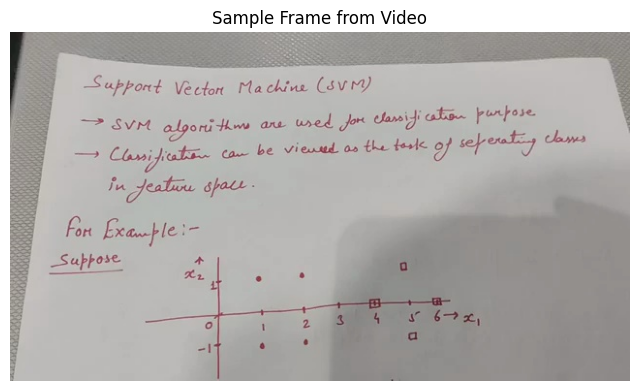

SECTION 9 COMPLETE: Sample frame displayed.


In [11]:
# ===========================================================================
# SECTION 9: DISPLAY SAMPLE FRAME
# ===========================================================================
# Purpose: Display one extracted frame for verification
if frame_paths:
    img = Image.open(frame_paths[0])
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample Frame from Video")
    plt.show()
    print("SECTION 9 COMPLETE: Sample frame displayed.")
else:
    print("SECTION 9 SKIPPED: No frames extracted.")

In [12]:
# ===========================================================================
# SECTION 10: GENERATE FINAL REPORT
# ===========================================================================
# Purpose: Compile metadata, summary, and visual text into a Markdown report
report = f"""
# Video Summary Report
## Metadata
- **Title**: {metadata['title']}
- **Description**: {metadata.get('description', 'N/A')[:200]}...
- **Duration**: {metadata.get('duration', 'N/A')} seconds
- **Upload Date**: {metadata.get('upload_date', 'N/A')}
- **Language**: {language}

## Summary (Mistral AI)
{summary}

## Visual Text
{visual_text[:1000] + '...' if len(visual_text) > 1000 else visual_text}
"""

# Save to file
with open("summary_report.md", "w") as f:
    f.write(report)
print("SECTION 10 COMPLETE: Report saved as 'summary_report.md'. Download from Files tab.")

SECTION 10 COMPLETE: Report saved as 'summary_report.md'. Download from Files tab.


In [13]:
# ===========================================================================
# SECTION 11: PIPELINE EXPLANATION
# ===========================================================================
# Purpose: Provide a detailed explanation of the pipeline and model choices
print("""
# Pipeline Explanation
## Steps:
1. **Video Download**: `yt-dlp` downloads the video and extracts metadata (e.g., title, duration).
2. **Transcript Extraction**: Uses `youtube-transcript-api` or `Whisper` for audio transcription, with `langdetect` for language detection.
3. **Summarization**: `Mistral AI` summarizes the transcript into 3-5 English sentences.
4. **Visual Extraction**: `OpenCV` extracts frames, `Tesseract` performs OCR (English or Hindi).
5. **Report Generation**: Combines outputs into a Markdown file.

## Model Choices:
- **yt-dlp**: Reliable, widely-used for YouTube video handling.
- **youtube-transcript-api**: Efficient for direct transcript access.
- **Whisper**: Open-source, multilingual transcription tool.
- **Mistral AI**: Powerful proprietary model for summarization.
- **OpenCV**: Standard for video frame extraction.
- **Tesseract**: Open-source OCR with English and Hindi support.
- **langdetect**: Simple, effective language detection.

## Why This Approach?
- Flexible for any YouTube link via `video_url`.
- Robust with fallback transcription (Whisper).
- Enhanced with visual text for CV relevance.
- Well-documented for technical walkthrough.

SECTION 11 COMPLETE: Pipeline explanation printed above.
""")

# ===========================================================================
# END OF PIPELINE
# ===========================================================================
print("Pipeline execution completed successfully!")


# Pipeline Explanation
## Steps:
1. **Video Download**: `yt-dlp` downloads the video and extracts metadata (e.g., title, duration).
2. **Transcript Extraction**: Uses `youtube-transcript-api` or `Whisper` for audio transcription, with `langdetect` for language detection.
3. **Summarization**: `Mistral AI` summarizes the transcript into 3-5 English sentences.
4. **Visual Extraction**: `OpenCV` extracts frames, `Tesseract` performs OCR (English or Hindi).
5. **Report Generation**: Combines outputs into a Markdown file.

## Model Choices:
- **yt-dlp**: Reliable, widely-used for YouTube video handling.
- **youtube-transcript-api**: Efficient for direct transcript access.
- **Whisper**: Open-source, multilingual transcription tool.
- **Mistral AI**: Powerful proprietary model for summarization.
- **OpenCV**: Standard for video frame extraction.
- **Tesseract**: Open-source OCR with English and Hindi support.
- **langdetect**: Simple, effective language detection.

## Why This Approach?
- F